<a href="https://colab.research.google.com/github/dtabuena/2HG/blob/main/Schaffer/Schaffer_Pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!python -V

Python 3.11.9


In [ ]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy as sci
import os
from tqdm import tqdm
import warnings
from IPython.display import clear_output
from datetime import datetime
import sys
import warnings
import shutil
import urllib
import pyabf
import statsmodels.api as sm  # For weighted least squares


In [ ]:
import urllib
response = urllib.request.urlretrieve('https://raw.githubusercontent.com/dtabuena/Resources/main/Matplotlib_Config/Load_FS6.py','Load_FS6.py')
%run Load_FS6.py

In [ ]:
workspace_dir = r'C:\Users\dennis.tabuena\Gladstone Dropbox\Dennis Tabuena\_Colab_OutBox\HMGB1_David'

In [ ]:

# lib_dir = os.path.join(workspace_dir,'code')
# os.makedirs(lib_dir,exist_ok=True)
# os.chdir(lib_dir)
# import_dir = 'https://raw.githubusercontent.com/dtabuena/Workshop/refs/heads/main/Schaffer/'
# to_import = ['Schaffer_Lib.ipynb']
# to_import = [import_dir+f for f in to_import]
# for source in to_import:
#     file = source.split('/')[-1]
#     urllib.request.urlretrieve(source,file)
#     %run $file


In [ ]:
file_name = r"C:\Users\dennis.tabuena\Gladstone Dropbox\Dennis Tabuena\_Colab_OutBox\HMGB1_David\2025x01x08_E3KI_F_P238_\sample.abf"

In [ ]:
file_name = r"C:\Users\dennis.tabuena\Gladstone Dropbox\Dennis Tabuena\_Colab_OutBox\HMGB1_David\2025x01x08_E3KI_F_P238_\2025x01x08_E3KI_F_P238_sagi_s001_0000.abf"

abf_rec = pyabf.ABF(file_name)

print(abf_rec.channelList)

[0, 1]


In [ ]:
a = pyabf.waveform.EpochSweepWaveform()
print(a)

Sweep epoch waveform


In [ ]:
import re

# Load the ABF file
abf_rec = pyabf.ABF(file_name)

# Extract header HTML content
header_html = abf_rec.headerHTML

# Define patterns for each highlighted entry
patterns = {
    "nWaveformEnable": r"nWaveformEnable = <code>\[(.*?)\]</code>",
    "nWaveformSource": r"nWaveformSource = <code>\[(.*?)\]</code>",
    "fEpochInitLevel": r"fEpochInitLevel = <code>\[(.*?)\]</code>",
    "fEpochLevelInc": r"fEpochLevelInc = <code>\[(.*?)\]</code>",
    "lEpochDurationInc": r"lEpochDurationInc = <code>\[(.*?)\]</code>",
    "lEpochInitDuration": r"lEpochInitDuration = <code>\[(.*?)\]</code>",
    "lEpochPulsePeriod": r"lEpochPulsePeriod = <code>\[(.*?)\]</code>",
    "lEpochPulseWidth": r"lEpochPulseWidth = <code>\[(.*?)\]</code>"
}

# Dictionary to store the extracted values
extracted_data = {}

# Extract the values using the patterns
for key, pattern in patterns.items():
    match = re.findall(pattern, header_html)
    if match:
        extracted_data[key] = [float(i) if '.' in i else int(i) for i in match[0].split(',')]

# Print the extracted data
for key, value in extracted_data.items():
    print(f"{key}: {value}")

nWaveformEnable: [0, 0, 0, 0, 1, 0, 0, 0]
nWaveformSource: [1, 1, 1, 1, 1, 1, 1, 1]
fEpochInitLevel: [0.0, 2.0, 0.0]
fEpochLevelInc: [0.0, 0.800000011920929, 0.0]
lEpochDurationInc: [0, 0, 0]
lEpochInitDuration: [250, 1, 500]
lEpochPulsePeriod: [0, 0, 0]
lEpochPulseWidth: [0, 0, 0]


In [ ]:
def build_epoch_trace(ch4_epochs,abf_rec):
    fs = abf_rec.sampleRate
    epoch_waveforms = []
    for s in abf_rec.sweepList:
        wave = []
        for ep in range(len(ch4_epochs['fEpochInitLevel'])):
            x_dur = ch4_epochs['lEpochInitDuration'][ep] + s*ch4_epochs['lEpochDurationInc'][ep]
            y_lev = ch4_epochs['fEpochInitLevel'][ep] + s*ch4_epochs['fEpochLevelInc'][ep]
            wave.append( np.ones(x_dur) * y_lev)
        wave=np.concatenate(wave,0)
        epoch_waveforms.append(wave)
    ep_time = np.arange(len(wave))/fs
    return epoch_waveforms,ep_time


In [ ]:
def pop_spike(time, stim, resp, units=['s', 'uA', 'mV'], to_plot=True):

    stim_ind = np.argmax(stim)
    stim_amp = stim[stim_ind]

    trig_bool = abs((stim - np.mean(stim))) / np.std(stim) > 3
    trig_ind = np.argsort(trig_bool)[-1]

    pos_peaks, _ = sci.signal.find_peaks(resp, prominence=0.1)
    neg_peaks, _ = sci.signal.find_peaks(-resp, prominence=0.1)

    if len(neg_peaks) == 0:
        # print('no peaks detected')
        return np.nan, stim_amp

    w1 = int(neg_peaks[0] + 0.001 / time[1])
    w2 = int(neg_peaks[0] + 0.022 / time[1])


    cell_resp = resp[range(w1, w2)]
    time = time-time[trig_ind]
    # Apply Gaussian smoothing
    cell_resp_smo = sci.ndimage.gaussian_filter1d(cell_resp, sigma=1)

    # Identify peaks
    resp_pos_peaks, _ = sci.signal.find_peaks(cell_resp_smo, prominence=0.1)
    resp_neg_peaks, _ = sci.signal.find_peaks(-cell_resp_smo, prominence=0.1)

    # Get top 2 positive peaks
    peak_amps = cell_resp[resp_pos_peaks]
    if len(peak_amps) < 2:
        # print('not enough positive peaks detected')
        return np.nan, stim_amp

    top_2 = np.argsort(peak_amps)[-2:]
    peak_amps = peak_amps[top_2]
    resp_pos_peaks = resp_pos_peaks[top_2]

    if len(resp_neg_peaks) == 0:
        # print('no negative peaks detected')
        return np.nan, stim_amp
    # Select the most prominent negative peak
    if len(resp_neg_peaks) > 1:
        resp_neg_peaks = resp_neg_peaks[np.argmax(-cell_resp[resp_neg_peaks])]
    else:
        resp_neg_peaks = resp_neg_peaks[0]

    # Extract x and y coordinates for the line fit
    x_top = time[range(w1, w2)][resp_pos_peaks]
    y_top = peak_amps

    # Fit a line between the top two positive peaks
    slope, intercept = np.polyfit(x_top, y_top, 1)

    # Predict the amplitude at the negative peak time
    x_neg = time[range(w1, w2)][resp_neg_peaks]
    y_pred = slope * x_neg + intercept

    # **Fix: Compute pop_amp using actual negative peak amplitude, not index**
    pop_peak = cell_resp[resp_neg_peaks]
    pop_amp = y_pred - pop_peak

    if to_plot:

        fig, ax = plt.subplots(figsize=(1.5, 1))
        ax.plot(time, resp, 'k')
        ax.plot(time[range(w1, w2)], cell_resp, 'k')
        ax.scatter(x_top, y_top, color='m', label="Top 2 Peaks")
        ax.scatter([x_neg], [pop_peak], color='c', label="Observed Negative Peak")

        # Plot the fitted line
        ax.plot(x_top, slope * x_top + intercept, 'g--', label="Fit Line")

        # Plot predicted y-value at the negative peak time
        ax.scatter([x_neg], [y_pred], color='b', marker='x', label="Predicted Y")

        # Plot Amplitude
        ax.plot( [x_neg, x_neg] ,  [ pop_peak,y_pred],'r')

        # ax.axvline(time[trig_ind], color='r', linestyle="--", label="Trigger")
        ax.set_xlim(time[trig_ind] - 0.004, time[trig_ind] + 0.02)
        # ax.axvline(time[w1], color='orange', linestyle="--")
        # ax.axvline(time[w2], color='orange', linestyle="--")
        ax.set_ylabel('Somatic LFP (mV)')
        ax.set_xlabel('Post Stim Time (ms)')
        ax.set_title('CA1 Compound Action Potential')
        # plt.tight_layout()

    return pop_amp, stim_amp


In [ ]:

def EPSP_slope(time,stim,resp,units=['s','uA','mV'],to_plot=True,ax=None):

    stim_ind = np.argmax(stim)
    stim_amp = stim[stim_ind]

    trig_bool = abs((stim-np.mean(stim)))/np.std(stim)>3
    trig_ind = np.argsort(trig_bool)[-1]

    pos_peaks, _ = sci.signal.find_peaks(resp, prominence=0.1)
    neg_peaks, _ = sci.signal.find_peaks(-resp, prominence=0.1)

    if len(neg_peaks)==0:
        # print('no peaks detected')
        return np.nan, stim_amp



    w1 = int(trig_ind + 0.0028/time[1])
    w2 = int(w1 + 0.005/time[1])

    epsp = resp[range(w1,w2)]
    time = time-time[trig_ind]

    # fig,ax2 = plt.subplots(2,1,figsize=(3,2))

    epsp_diff = np.diff(epsp,prepend=0)
    epsp[epsp_diff>0]=np.nan
    epsp_diff[epsp_diff>0]=np.nan
    # ax2[0].plot(epsp)
    # ax2[1].plot(epsp_diff,'k')
    epsp[-epsp_diff<np.nanpercentile(-epsp_diff,50)]=np.nan
    # ax2[0].plot(epsp,'r')
    # ax2[1].plot(np.diff(epsp,prepend=0),'r')


    mask = ~np.isnan(epsp)  # Mask to filter out NaN values
    x_clean = time[range(w1,w2)][mask]
    y_clean = epsp[mask]

    # Fit a line
    coefficients = np.polyfit(x_clean, y_clean, 1)  # Degree 1 for linear fit
    epsp_slope, intercept = coefficients

    x_fit = [time[w1]-0.001,time[w1]+0.003]
    y_fit = np.polyval(coefficients, x_fit)
    # ax.plot(time[range(w1,w2)],epsp,'r')

    if to_plot:

        if ax is None:
            fig,ax = plt.subplots(figsize=(1.5,1))
        ax.plot(time,resp,'k')
        # ax.axvline(time[trig_ind], color='r', linestyle="--", label="Trigger")
        ax.set_xlim(time[trig_ind]-.004,time[trig_ind]+.02)
        ax.scatter(time[pos_peaks],resp[pos_peaks],color='m')
        ax.scatter(time[neg_peaks],resp[neg_peaks],color='c')

        ax.scatter(x_clean,y_clean,color='green')


        ax.plot(x_fit,y_fit, color='red')
        # ax.axvline(time[w1],color='orange')
        # ax.axvline(time[w2],color='orange')
        ax.set_ylabel('Dendritic LFP (mV)')
        ax.set_xlabel('Post Stim Time (ms)')
        ax.set_title('CA1 Dendritic Response')
        # plt.tight_layout()
    return -epsp_slope, stim_amp


In [ ]:
def read_ch4_epochs(abf_rec,pad_x=True):
    header_html = abf_rec.headerHTML
    patterns = {"fEpochInitLevel": r"fEpochInitLevel = <code>\[(.*?)\]</code>",
                "fEpochLevelInc": r"fEpochLevelInc = <code>\[(.*?)\]</code>",
                "lEpochDurationInc": r"lEpochDurationInc = <code>\[(.*?)\]</code>",
                "lEpochInitDuration": r"lEpochInitDuration = <code>\[(.*?)\]</code>",}
    ch4_epochs = {}
    for key, pattern in patterns.items():
        match = re.findall(pattern, header_html)
        if match:
            ch4_epochs[key] = [float(i) if '.' in i else int(i) for i in match[0].split(',')]
    if pad_x:
        x_len = len(abf_rec.sweepX)
        holding_pct = int(x_len*.015)
        ep_len = np.sum(ch4_epochs['lEpochInitDuration'])
        delta = x_len - ep_len - holding_pct
        ch4_epochs["fEpochInitLevel"].append(0.0)
        ch4_epochs["fEpochLevelInc"].append(0.0)
        ch4_epochs["lEpochDurationInc"].append(0)
        ch4_epochs["lEpochInitDuration"].append(delta)
        ch4_epochs["fEpochInitLevel"] = [0] + ch4_epochs["fEpochInitLevel"]
        ch4_epochs["fEpochLevelInc"] = [0] + ch4_epochs["fEpochLevelInc"]
        ch4_epochs["lEpochDurationInc"] = [0] + ch4_epochs["lEpochDurationInc"]
        ch4_epochs["lEpochInitDuration"] = [holding_pct] + ch4_epochs["lEpochInitDuration"]
    return ch4_epochs




In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

def analyze_EPSP_ramp(abf_rec, to_plot=False):
    ch4_epochs = read_ch4_epochs(abf_rec)
    epoch_waveforms,ep_time =  build_epoch_trace(ch4_epochs,abf_rec)

    epsp_list = []
    stim_list = []
    sweep_indices = []

    for i, swp in enumerate(abf_rec.sweepList):
        abf_rec.setSweep(swp, 1)  # Set channel to 1
        stim = epoch_waveforms[swp]
        abf_rec.setSweep(swp, 1)  # Ensure the correct channel
        time = abf_rec.sweepX
        resp = abf_rec.sweepY
        epsp_slope, stim_amp = EPSP_slope(time, stim, resp, to_plot=False)

        epsp_list.append(epsp_slope)
        stim_list.append(stim_amp)
        sweep_indices.append(i)

    epsp_list = np.array(epsp_list, dtype=np.float64)
    stim_list = np.array(stim_list, dtype=np.float64)
    sweep_indices = np.array(sweep_indices, dtype=np.float64)

    valid_mask = ~np.isnan(epsp_list) & ~np.isnan(stim_list)
    epsp_list = epsp_list[valid_mask]
    stim_list = stim_list[valid_mask]
    sweep_indices = sweep_indices[valid_mask]

    if len(epsp_list) < 2:
        # print("Not enough valid data points for regression.")
        return np.nan

    num_sweeps = len(sweep_indices)
    cutoff = int(0.75 * num_sweeps)
    weights = np.ones(num_sweeps)

    weights[:cutoff] = np.linspace(1, 0.5, cutoff)
    weights[cutoff:] = 0.5

    X = sm.add_constant(stim_list)
    model = sm.WLS(epsp_list, X, weights=weights).fit()

    epsp_ramp_slope = model.params[1]

    stim_range = np.linspace(stim_list.min(), stim_list.max(), 100)
    epsp_fit = model.predict(sm.add_constant(stim_range))

    if to_plot:
        fig_epsp_ramp, ax = plt.subplots(1, figsize=(1.5, .75))
        ax.scatter(stim_list, epsp_list, label="Data", color="k")
        ax.plot(stim_range, epsp_fit, label="Weighted Fit", color="r")
        ax.set_xlabel("Stimulus\nAmplitude (mA)")
        ax.set_ylabel("EPSP Slope\n(mV/ms)")
        ax.set_title(abf_rec.abfID)
        plt.show()

    return epsp_ramp_slope,fig_epsp_ramp



In [ ]:
def analyze_pop_ramp(abf_rec, to_plot=False):
    ch4_epochs = read_ch4_epochs(abf_rec)
    epoch_waveforms,ep_time =  build_epoch_trace(ch4_epochs,abf_rec)


    pop_list = []
    stim_list = []

    for swp in abf_rec.sweepList:
        abf_rec.setSweep(swp, 0)  # Set the current sweep
        stim = epoch_waveforms[swp]
        time = abf_rec.sweepX
        resp = abf_rec.sweepY
        pop_amp, stim_amp = pop_spike(time, stim, resp, to_plot=False)

        pop_list.append(pop_amp)
        stim_list.append(stim_amp)

    # Convert lists to NumPy arrays
    pop_list = np.array(pop_list, dtype=np.float64)
    stim_list = np.array(stim_list, dtype=np.float64)

    # **Remove NaN values**
    valid_mask = ~np.isnan(pop_list) & ~np.isnan(stim_list)
    pop_list = pop_list[valid_mask]
    stim_list = stim_list[valid_mask]
    print(stim_list)

    # **Check for valid data**
    if len(pop_list) < 2:
        # print("Not enough valid data points for regression.")
        return np.nan  # Return NaN if fitting is not possible

    # **Bias towards middle values**
    median_stim = np.median(stim_list)
    weights = np.exp(-np.abs(stim_list - median_stim))  # Higher weight for middle points

    # **Fit a weighted least squares (WLS) regression**
    X = sm.add_constant(stim_list)  # Add intercept term
    print(pop_list)
    model = sm.WLS(pop_list, X, weights=weights).fit()

    # Extract slope from model
    pop_ramp_slope = model.params[1]  # The coefficient of stim_list (first column after constant)

    # **Generate fitted values**
    stim_range = np.linspace(stim_list.min(), stim_list.max(), 100)
    pop_fit = model.predict(sm.add_constant(stim_range))

    if to_plot:
        fig_pop_ramp, ax = plt.subplots(1,figsize=(1.5,.75))
        ax.scatter(stim_list, pop_list, label="Data", color="k")
        ax.plot(stim_range, pop_fit, label="Weighted Fit", color="r")
        ax.set_xlabel("Stimulus\nAmplitude(mA)")
        ax.set_ylabel("Population Spike\nAmplitude (mV)")
        ax.set_title(abf_rec.abfID)
        plt.show()

    return pop_ramp_slope,fig_pop_ramp


In [ ]:
def analyze_lfp_wash_in(abf_rec,switch_time,control_time=10,wash_delta=1.5,to_plot=True):
    switch_time = switch_time + wash_delta
    ch4_epochs = read_ch4_epochs(abf_rec)
    epoch_waveforms,ep_time =  build_epoch_trace(ch4_epochs,abf_rec)

    epsp_list = []
    stim_list = []
    pop_list = []
    sweep_indices = []


    for swp in abf_rec.sweepList:
        abf_rec.setSweep(swp, 0)  # Set the current sweep
        stim = epoch_waveforms[swp]
        abf_rec.setSweep(swp, 0)
        time = abf_rec.sweepX
        resp = abf_rec.sweepY
        pop_amp, stim_amp = pop_spike(time, stim, resp, to_plot=swp<1)
        abf_rec.setSweep(swp, 1)
        resp = abf_rec.sweepY
        epsp_slope, stim_amp = EPSP_slope(time, stim, resp, to_plot=swp<1)


        pop_list.append(pop_amp)
        epsp_list.append(epsp_slope)
        stim_list.append(stim_amp)

    pop_arr = np.array(pop_list)
    epsp_arr = np.array(epsp_list)
    stim_arr = np.array(stim_list)

    control_inds = np.logical_and(abf_rec.sweepTimesMin> switch_time-control_time,abf_rec.sweepTimesMin< switch_time)

    rel_sweep_time = abf_rec.sweepTimesMin - (switch_time)

    epsp_base_line = np.mean(epsp_arr[control_inds])
    pop_base_line = np.mean(pop_arr[control_inds])

    norm_pop_arr = pop_arr/pop_base_line
    norm_epsp_arr = epsp_arr/epsp_base_line

    window_size = 7
    kernel = np.ones(window_size) / window_size

    if to_plot:
        fig_pop_ramp, ax = plt.subplots(2,1,figsize=(3,2))
        ax[0].scatter(rel_sweep_time, norm_pop_arr,color='k')
        ax[0].plot(rel_sweep_time, sci.ndimage.uniform_filter1d(norm_pop_arr, size=window_size, mode='reflect'),color='k')

        ax[0].axvline(0,color='r')
        ax[0].axhline(1,color='k', linestyle="--")
        ax[0].set_ylim([0.5, np.max(norm_pop_arr)*1.1])
        ax[0].set_ylabel('Rel Pop. Change')

        ax[1].scatter(rel_sweep_time, norm_epsp_arr,color='k')
        ax[1].plot(rel_sweep_time, sci.ndimage.uniform_filter1d(norm_epsp_arr, size=window_size, mode='reflect'),color='k')
        ax[1].axvline(0,color='r')
        ax[1].axhline(1,color='k', linestyle="--")
        ax[1].set_ylim([0.5, np.max(norm_epsp_arr)*1.1])
        ax[1].set_ylabel('Rel EPSP Change')
        ax[1].set_xlabel('HMGB1 Wash in Time (min)')
        plt.tight_layout()
        plt.show()



In [ ]:


# epsp_slope, stim_amp = EPSP_slope(time, stim, resp, to_plot=True, ax=ax)
# # switch_time = switch_time + wash_delta
# ch4_epochs = read_ch4_epochs(abf_rec)
# epoch_waveforms,ep_time =  build_epoch_trace(ch4_epochs,abf_rec)

# epsp_list = []
# stim_list = []
# pop_list = []
# sweep_indices = []

# fig,ax=plt.subplots(1,figsize=(5,2))

# for swp in abf_rec.sweepList:
#     abf_rec.setSweep(swp, 0)  # Set the current sweep
#     stim = epoch_waveforms[swp]
#     abf_rec.setSweep(swp, 0)
#     abf_rec.setSweep(swp, 1)
#     time = abf_rec.sweepX
#     resp = abf_rec.sweepY
#     epsp_slope, stim_amp = EPSP_slope(time, stim, resp, to_plot=True, ax=ax)

[3.6 4.4 5.2 6.  6.8 7.6]
[0.7371 1.083  1.5585 2.1013 2.3363 2.5428]


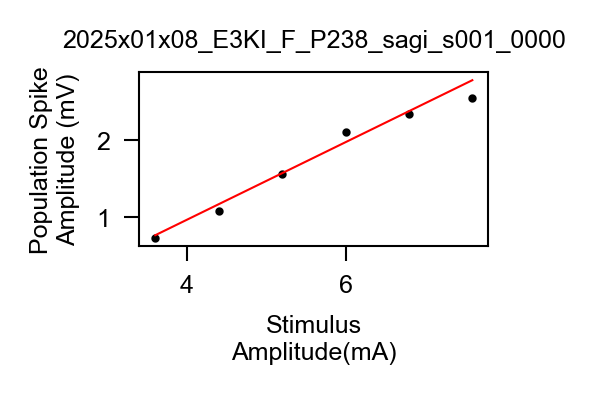

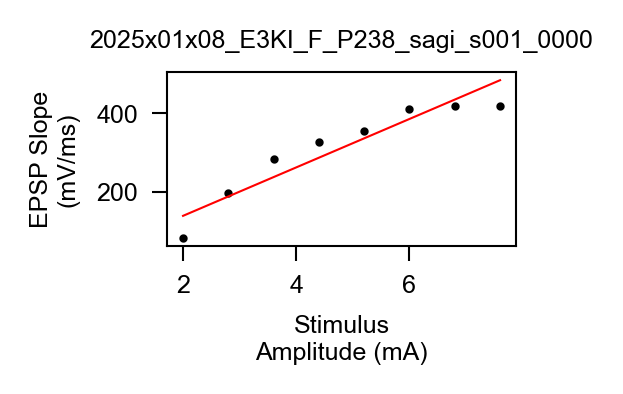

In [ ]:
file_name = r"C:\Users\dennis.tabuena\Gladstone Dropbox\Dennis Tabuena\_Colab_OutBox\HMGB1_David\2025x01x08_E3KI_F_P238_\2025x01x08_E3KI_F_P238_sagi_s001_0000.abf"
abf_rec = pyabf.ABF(file_name)
pop_ramp_slope,fig_pop_ramp = analyze_pop_ramp(abf_rec,to_plot=True)
epsp_ramp_slope,fig_epsp_ramp = analyze_EPSP_ramp(abf_rec,to_plot=True)

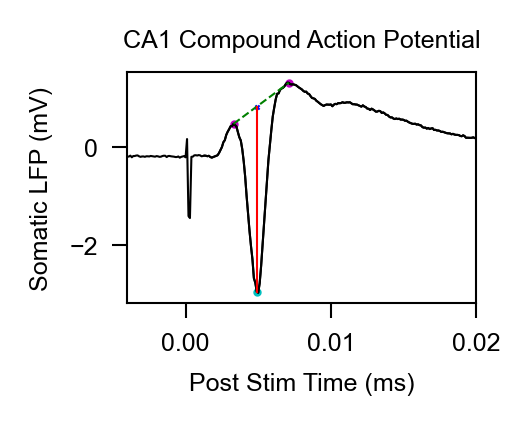

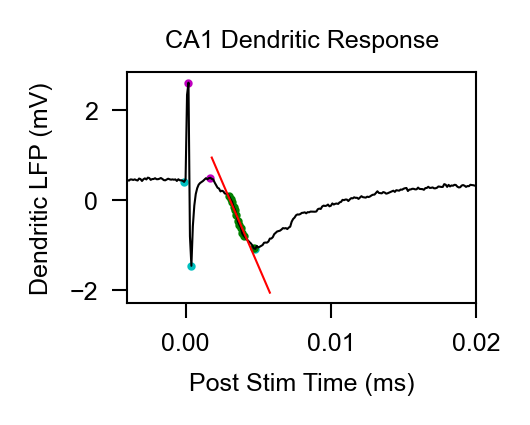

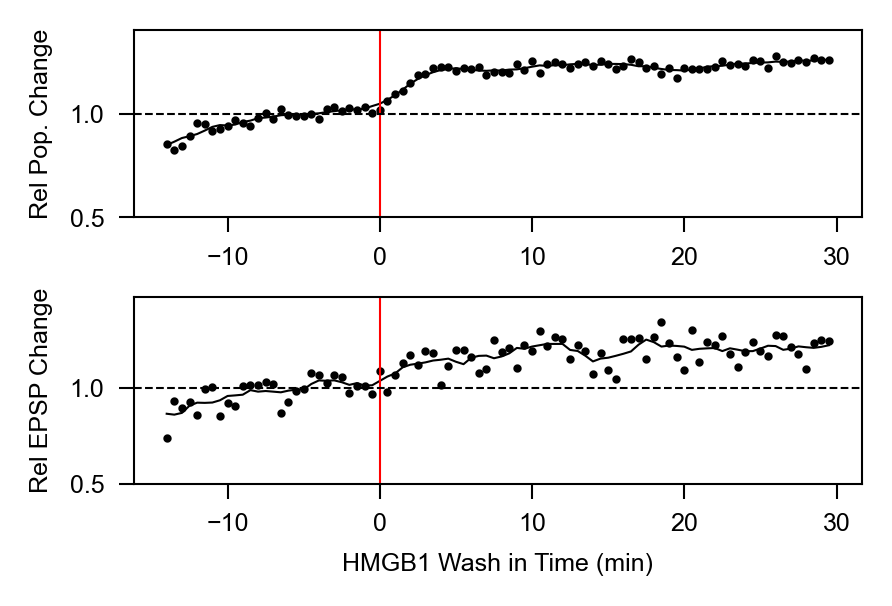

In [ ]:
file_name = r"C:\Users\dennis.tabuena\Gladstone Dropbox\Dennis Tabuena\6_Recordings\Today\2025x02x19_E4KI_F_P225_\2025x02x19_E3KI_F_P229_sagi_s001_0004.abf"
abf_rec = pyabf.ABF(file_name)
analyze_lfp_wash_in(abf_rec,12.5)